In [1]:
from dotenv import load_dotenv
from huggingface_hub import login

login()

## Loading Image


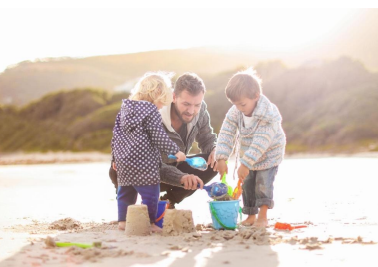

In [2]:
import base64
from pathlib import Path
from PIL import Image

from IPython.display import HTML

img_path = Path("images/test_img.png")
img_base64 = base64.b64encode(img_path.read_bytes()).decode("utf-8")
rgb_image = Image.open("images/test_img.png").convert('RGB')
HTML(f'<img src="data:image/png;base64,{img_base64}">')

## Performing PaliGemma and Phi3V captioning

In [3]:
import torch
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration

paligemma_model_id = "google/paligemma-3b-mix-224"
device = "cuda:0"
dtype = torch.bfloat16

paligemma_model = PaliGemmaForConditionalGeneration.from_pretrained(
    paligemma_model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
).eval()
paligemma_processor = AutoProcessor.from_pretrained(paligemma_model_id)

prompt = "caption en"
model_inputs = paligemma_processor(text=prompt, images=rgb_image, return_tensors="pt").to(paligemma_model.device)
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    paligemma_generation = paligemma_model.generate(**model_inputs, max_new_tokens=200, do_sample=False)
    paligemma_generation = paligemma_generation[0][input_len:]
    paligemma_decoded = paligemma_processor.decode(paligemma_generation, skip_special_tokens=True)
    print(paligemma_decoded)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
from transformers import AutoModelForCausalLM, AutoProcessor

phi3v_model_id = "microsoft/Phi-3-vision-128k-instruct" 
phi3v_model = AutoModelForCausalLM.from_pretrained(phi3v_model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto")
phi3v_processor = AutoProcessor.from_pretrained(phi3v_model_id, trust_remote_code=True) 
messages = [ 
    {"role": "user", "content": "<|image_1|>\nWhat is shown in this image?"}, 
] 
prompt = phi3v_processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = phi3v_processor(prompt, [rgb_image], return_tensors="pt").to("cuda:0") 
generation_args = { 
    "max_new_tokens": 500, 
    "temperature": 0.0, 
    "do_sample": False, 
} 
phi3v_generate_ids = phi3v_model.generate(**inputs, eos_token_id=phi3v_processor.tokenizer.eos_token_id, **generation_args) 
phi3v_generate_ids = phi3v_generate_ids[:, inputs['input_ids'].shape[1]:]
phi3v_response = phi3v_processor.batch_decode(phi3v_generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0] 

phi3v_response

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\axeld\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


The image shows a family of three playing on a sandy beach. There are two adults and a child. They are engaged in building a sandcastle together. The beach is near a body of water, and there are hills in the background. The weather appears to be sunny.


## Performing LLM double-check

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

gpt4o = ChatOpenAI(model="gpt-4o", temperature=0)

system_prompt = "You are an helpful AI assistant."
verification_human = """This is a hard problem. Carefully summarize in ONE detailed caption
based on the following two captions by different (possibly incorrect)
people describing the same scene. Be sure to describe everything, and
avoid hallucination.

<caption_1> {caption_1} </caption_1>
<caption_2> {caption_2} </caption_2>

Summary:"""
verification_prompt = ChatPromptTemplate.from_messages([("system", system_prompt), ("human", verification_human)])
verification_chain = verification_prompt | gpt4o
model_output = verification_chain.invoke({"caption_1":paligemma_decoded, "caption_2":phi3v_response})
full_caption = model_output.content
full_caption

'A family of three, consisting of one man, one woman, and one child, is playing on a sunny, sandy beach near a body of water with hills in the background. They are engaged in building a sandcastle together.'

In [7]:
object_parser_human = """I want to use an object detector to check the correctness of an image
caption obtained by an image caption model. Can you help to parse the
caption below and list all objects that could be detected with an object
detection model in the image? Please only list the object name and
ignore the description. Please use singular for all listed objects.
Caption: {full_caption}.
Please concatenate them together with “. ” as separation
Output:"""
object_parser_prompt = ChatPromptTemplate.from_messages([("system", system_prompt), ("human", object_parser_human)])
object_parser_chain = object_parser_prompt | gpt4o
model_output = object_parser_chain.invoke({"full_caption": full_caption})
item_list = model_output.content
item_list

'family. man. woman. child. beach. water. hill. sandcastle'

## Performing Grounding Dino Check

In [8]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda:0"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image = Image.open(img_path).convert('RGB')

inputs = processor(images=image, text=item_list, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)[0]
results

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

c:\Users\axeld\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\cpp_extension.py:384: UserWarning: Error checking compiler version for cl: [WinError 2] Le fichier spécifié est introuvable
  warnings.warn(f'Error checking compiler version for {compiler}: {error}')
c:\Users\axeld\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Could not load the custom kernel for multi-scale deformable attention: Command '['where', 'cl']' returned non-zero exit status 1.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: Le module spécifié est introuvable.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleD

{'scores': tensor([0.8232, 0.7035, 0.6646, 0.7520, 0.7546, 0.6299], device='cuda:0'),
 'labels': ['child', 'woman', 'beach', 'man', 'family', 'hill'],
 'boxes': tensor([[ 2.1337e+02,  6.8352e+01,  2.8662e+02,  2.2766e+02],
         [ 1.0870e+02,  7.1610e+01,  1.8873e+02,  2.3215e+02],
         [ 2.5482e-02,  1.5328e+02,  3.7802e+02,  2.6670e+02],
         [ 1.5715e+02,  7.2307e+01,  2.1827e+02,  2.0892e+02],
         [ 1.0680e+02,  6.6965e+01,  2.8811e+02,  2.3316e+02],
         [-2.4401e-02,  4.5412e+01,  3.7798e+02,  1.5756e+02]], device='cuda:0')}

In [9]:
label_list = list(set(results["labels"]))
label_dict = {}
for label in label_list:
    label_dict[label] = 0
for (score, label, box) in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 1) for i in box.tolist()]
    if round(score.item(), 2) > 0.5:
        label_dict[label] += 1

In [10]:
detection_list = []
for label, n_detection in label_dict.items():
    detection_dict = {"object": label, "number": n_detection}
    detection_list.append(detection_dict)
detection_list

[{'object': 'woman', 'number': 1},
 {'object': 'child', 'number': 1},
 {'object': 'man', 'number': 1},
 {'object': 'family', 'number': 1},
 {'object': 'beach', 'number': 1},
 {'object': 'hill', 'number': 1}]

## Updating Caption

In [11]:
final_captioning_human = """Objective: parse and modify image captions using the results from an
object detection model (may have hallucination).
I will put the detection results to you in the following format:
[“object”: detected object name, “number”: number of detected object
(N)].

Please follow the following steps:
Instructions:
Parse the object in the caption, (Note: only parse and modify the object
(not color, action, size, shape, or other descriptions))
1. If the object was detected by the detection model, keep everything
including all descriptions. For instance, if the original caption is: “a
black and white panda toy”, if the toy was detected, keep all content
even though the “panda” and “black and white” are not detected. Keep
all descriptions about color, shape, actions .etc.
2. If the subject object was not detected, remove only the object. Do
NOT remove color, shape, action, text and other descriptions.
3. Only decrease the object number if the detected object number is
smaller than the caption number.
This is a hard problem. Please minimize modifications of the
caption, and list all changes made along with the reasoning.
—BEGIN Detection results: —
{detection_results}
—END Detection results—
—BEGIN Raw caption: —
{full_caption}
—END Raw caption—
Please give the output in the following format:
Modification:
Updated caption:
"""
final_captioning_prompt = ChatPromptTemplate.from_messages([("system", system_prompt), ("human", final_captioning_human)])
final_captioning_chain = final_captioning_prompt | gpt4o
model_output = final_captioning_chain.invoke({"detection_results": detection_list, "full_caption": full_caption})
final_caption = model_output.content
final_caption

Modification:
1. No changes were made to the objects "woman," "child," "man," "family," "beach," and "hill" as they were all detected by the model.
2. No changes were made to the number of objects since the detected numbers match the caption numbers.

Updated caption:
A family of three, consisting of one man, one woman, and one child, is playing on a sunny, sandy beach near a body of water with hills in the background. They are engaged in building a sandcastle together.


## Comparing captions

In [12]:
from openai import OpenAI

client = OpenAI()

evaluator_human = """You are responsible for judging the quality of image captions generated
by computer programs. You will be presented with an image and
captions describing the image. One of the captions is a reference
caption and you are responsible for comparing other captions against
the reference caption, one by one. Please evaluate captions in the
following two aspects:
1. Correctness. A good caption should correctly describe image
content, including the major objects and the surrounding scene.
2. Detailedness. A good caption should contain rich details about
the image content, for example, spatial location of objects, clothing
and actions of people, color, counting of objects, texts in the image, etc.
Given the image and a reference caption, you need to make decisions as to whether or not the given captions are better or worse than
the reference caption in describing the overall image.
This is a difficult task. You should first evaluate the reference
caption for the given image. And then evaluate each caption in the
same way and compare against the reference caption. You should think
out loud about your eventual conclusion for each caption, enumerating
reasons why each of the captions is better or worse compared with the
reference caption. After thinking out loud, you should output either
“Better” or “Worse” for each caption depending on whether you think
the caption is a better description of the image than the reference
caption.
Reference Caption: {final_caption}
Caption 1: {caption_1}
Caption 2: {caption_2}
You must keep your thinking out loud and respond in less than
500 words. Please summarize your judgment at the end using the
following format:
Caption 1: Better or Worse
...
Caption 4: Better or Worse"""
message_text = evaluator_human.format(**{"final_caption": final_caption, "caption_1":paligemma_decoded, "caption_2": phi3v_response})
response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "user",
      "content": [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{img_base64}",  # noqa: E501
            },
        },
        {"type": "text", "text": message_text},
      ],
    }
  ],
  max_tokens=1000,
)
evaluation = response.choices[0].message.content
print(evaluation)

Okay, let's evaluate the reference caption first:

Reference caption: "A family of three, consisting of one man, one woman, and one child, is playing on a sunny, sandy beach near a body of water with hills in the background. They are engaged in building a sandcastle together."

This caption is:
- Correct about the scene depicting a family playing on a beach.
- Incorrect as there is a discrepancy in the gender identification; the image shows one man and two children (one younger girl and one older boy). 
- Detailed in mentioning the sunny weather, sandy beach, hills, and activity of building a sandcastle.
  
This provides a solid foundation but has an inaccuracy in the description of family members.

Now, let's evaluate the provided captions.

### Caption 1:
"A man and two children are playing in the sand."
- Correctness:
  - Correctly identifies a man and two children playing in the sand.
  - Misses the context that they are building a sandcastle and leaves out the scene's broader cont